# Fake News and Misinformation Detection by Topic Modeling Assisted Classification

Purpose: Given a labeled dataset, test the ability to use a topic modeling algorithm to create clusters of topics to flag a new document for fake news or misinformation

### Steps:
1. Import libraries and datasets then begin initial prep on dataset.  
    - Split dataset into training and testing dataset (80/20). 
    - Split training dataset into "true" or "fake" news by already given "misinformation" flag.
2. Preprocessing:

    - 2.1. Lemmatization - create an output that creates words that are similiar enough to be considered the same word and help find stronger topics
    - 2.2. Generate words - create a list of words from the document and begin first iteration of removing gensim-known stop words

    - 2.3. Create Bigrams and Trigrams - combine words to create phrases that hold greater meaning than individual words
    - 2.4. Remove stop words via gensim stopwords and TF-IDF then output a corpus and id2bow dictionary for training
    
3. Train two models: True News Model and Fake News Model
    - Currently being done for all combinations of the following parameter settings:
        num_topic = 35, 75, 105, 140
        chunksize = 250, 500, 1000, 5000
        passes = 5, 15, 30, 60
4. Test testing dataset on training models
    - 4.1 Run create Sort function too find max score from the output of a test document.
    - 4.2 Prepare test documents similarly done to training datasets
    - 4.3 Run either a or b
        a. Run test on both True News Model and Fake News Model. Determine flag based on which output is closest to the models (First by the number of related topics and then by the max score of the all their topics.)
        b. Run test on only Fake News Model. Determine flag based on if the max score beats a given threshold.
    

In [1]:
## 1. Import libraries and datasets then begin initial prep on dataset. 

import re
import numpy as np
import pandas as pd
from pprint import pprint
import json
import time
import datetime

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models import Nmf
from gensim.models import LdaModel
from gensim.models import LsiModel
from gensim.models import TfidfModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis  # don't skip this
import matplotlib.pyplot as plt
#%matplotlib inline

# stop words
from nltk.corpus import stopwords

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

# Tokenize the documents
from nltk.tokenize import RegexpTokenizer

training_file = 'tables/training_dataset.csv'
testing_file = 'tables/testing_dataset.csv'
training_df = pd.read_csv(training_file)
testing_df = pd.read_csv(testing_file)
stopwords = stopwords.words('english')

true_training_df = training_df[training_df['misinformation']==0]
fake_training_df = training_df[training_df['misinformation']==1]

## 2. Preprocessing:
2.1. Lemmatization - create an output that creates words that are similiar enough to be considered the same word and help find stronger topics

2.2. Generate words to create a list of words from the document and begin first iteration of removing gensim-known stop words

2.3. Create Bigrams and Trigrams - combine words to create phrases that hold greater meaning than individual words

2.4. Remove stop words via gensim stopwords and TF-IDF then output a corpus and id2bow dictionary for training

In [2]:
## 2.1. Lemmatization - create an output that creates words that are similiar enough to be considered the same word and help find stronger topics

def lemmatization(texts, allowed_posttags=["NOUN", "ADJ", "VERBS", "ADV"]):
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

    texts_out = []
    for text in texts:
        doc = nlp(text) 
        new_text = []

        for token in doc:
            #print(token)
            if token.pos_ in allowed_posttags:
                new_text.append(token.lemma_)

        final = " ".join(new_text)
        texts_out.append(final)

    return texts_out

lemmatized_texts_true=lemmatization(true_training_df['text'])
lemmatized_texts_fake=lemmatization(fake_training_df['text'])

#print(lemmatized_texts[0]])

In [3]:
## 2.2. Generate words to create a list of words from the document and begin first iteration of removing gensim-known stop words

def gen_words(texts):
    final = []

    for text in texts:
        new = gensim.utils.simple_preprocess(text, deacc=True)

        final.append(new)

    return final

data_words_true = gen_words(lemmatized_texts_true)
data_words_fake = gen_words(lemmatized_texts_fake)

In [4]:
## 2.3. Create Bigrams and Trigrams - combine words to create phrases that hold greater meaning than individual words

#BIGRAMS and TRIGRAMS
bigram_phrases_true = gensim.models.Phrases(data_words_true, min_count=5, threshold=100)
bigram_phrases_fake = gensim.models.Phrases(data_words_fake, min_count=5, threshold=100)
trigram_phrases_true = gensim.models.Phrases(bigram_phrases_true[data_words_true], threshold=100)
trigram_phrases_fake = gensim.models.Phrases(bigram_phrases_fake[data_words_fake], threshold=100)

bigram_true = gensim.models.phrases.Phraser(bigram_phrases_true)
bigram_fake = gensim.models.phrases.Phraser(bigram_phrases_fake)
trigram_true = gensim.models.phrases.Phraser(trigram_phrases_true)
trigram_fake = gensim.models.phrases.Phraser(trigram_phrases_fake)

def make_bigrams(texts, bigram):
    return(bigram[doc] for doc in texts)

def make_trigram(texts, trigram, bigram):
    return(trigram[bigram[doc]] for doc in texts)

data_bigrams_true = make_bigrams(data_words_true, bigram_true)
data_bigrams_fake = make_bigrams(data_words_fake, bigram_fake)

data_bigrams_trigrams_true = make_trigram(data_words_true, trigram_true, bigram_true)
data_bigrams_trigrams_true_list = list(data_bigrams_trigrams_true)

data_bigrams_trigrams_fake = make_trigram(data_words_fake, trigram_fake, bigram_fake)
data_bigrams_trigrams_fake_list = list(data_bigrams_trigrams_fake)


# print(data_bigrams_trigrams_true_list[0])
# print(data_bigrams_trigrams_fake_list[0])

In [5]:
## 2.4. Remove stop words via gensim stopwords and TF-IDF then output a corpus and id2bow dictionary for training
def tfidf_remove(data_bigrams_trigrams_list):
    id2word = corpora.Dictionary(data_bigrams_trigrams_list)

    texts = data_bigrams_trigrams_list

    corpus = [id2word.doc2bow(text) for text in texts]

    #print(corpus[0][0:20])

    tfidf = TfidfModel(corpus=corpus, id2word=id2word)

    low_value = 0.03
    words = []
    words_missing_in_tfidf = []

    for i in range(0, len(corpus)):
        bow = corpus[i]
        low_value_words = []
        tfidf_ids = [id for id, value in tfidf[bow]]
        bow_ids = [id for id, value in bow]
        #print(Sort(tfidf[bow]))
        low_value_words = [id for id, value in tfidf[bow] if value < low_value]
        drops = low_value_words+words_missing_in_tfidf
        for item in drops:
            words.append(id2word[item])
        words_missing_in_tfidf = [id for id in bow_ids if id not in tfidf_ids] # The words with tf-idf score 0 will be missing

        new_bow = [b for b in bow if b[0] not in low_value_words and b[0] not in words_missing_in_tfidf]
        corpus[i] = new_bow
    
    return corpus, id2word

corpus_true, id2word_true = tfidf_remove(data_bigrams_trigrams_true_list)

corpus_fake, id2word_fake = tfidf_remove(data_bigrams_trigrams_fake_list)

## 3. Train two models: True News Model and Fake News Model
   - Currently being done for all combinations of the following parameter settings:
        - num_topic = 35, 75, 105, 140
        - chunksize = 250, 500, 1000, 5000
        - passes = 5, 15, 30, 60

In [20]:
## function to create LDA models

def create_LDA_models(settings, corpus_true, corpus_fake, id2word_true, id2word_fake):
    models_metadata = []
    for setting in settings:
        num_topics, chunksize = setting
        start_time = time.time()
        save_folder = 'models/training_models/lda/'
        setting_name = 'setting_'+str(num_topics)+'_'+str(chunksize)
        true_save_folder = save_folder+'lda_model_true_'+setting_name+'.model'
        fake_save_folder = save_folder+'lda_model_fake_'+setting_name+'.model'


        lda_model_true = LdaModel(  corpus=corpus_true,
                                    id2word=id2word_true,
                                    num_topics=num_topics,
                                    chunksize=chunksize)
        complete_time_true = time.time()
        lda_model_fake = LdaModel(  corpus=corpus_fake,
                                    id2word=id2word_fake,
                                    num_topics=num_topics,
                                    chunksize=chunksize)

        complete_time_fake = time.time()

        complete_time_true_diff = complete_time_true - start_time
        complete_time_fake_diff = complete_time_fake - complete_time_true

        #print(num_topics, chunksize, passes, time_diff, true_model_setting_name, fake_model_setting_name)
        #print(true_save_folder, fake_save_folder)

        metadata = { "Setting Name": setting_name
                    , "num_topics": num_topics
                    , "chunksize": chunksize
                    , "Time to Complete True Model (s)":  complete_time_true_diff
                    , "Time to Complete Fake Model (s)": complete_time_fake_diff
                    , "Total Time to Complete Models (s)": complete_time_true_diff + complete_time_fake_diff
                    } 

        models_metadata.append(metadata)

        lda_model_true.save(true_save_folder)
        lda_model_fake.save(fake_save_folder)

        print('LDA Modeling: Completed Models for', setting_name, 'Completed in ', time.strftime('%H:%M:%S', time.gmtime(complete_time_true_diff + complete_time_fake_diff)), ' at ', datetime.datetime.now().time())

    json_object = json.dumps(models_metadata, indent=4)

    with open('lda_models_metadata.json', 'w') as outfile:
        outfile.write(json_object)

    print('LDA Model Training Complete')

In [21]:
## Function to create NMF Models
def create_NMF_models(settings, corpus_true, corpus_fake, id2word_true, id2word_fake):
    models_metadata = []
    for setting in settings:
        num_topics, chunksize = setting
        start_time = time.time()
        save_folder = 'models/training_models/nmf/'
        setting_name = 'setting_'+str(num_topics)+'_'+str(chunksize)
        true_save_folder = save_folder+'nmf_model_true_'+setting_name+'.model'
        fake_save_folder = save_folder+'nmf_model_fake_'+setting_name+'.model'


        nmf_model_true = Nmf(  corpus=corpus_true,
                                    id2word=id2word_true,
                                    num_topics=num_topics,
                                    chunksize=chunksize)
        complete_time_true = time.time()
        nmf_model_fake = Nmf(  corpus=corpus_fake,
                                    id2word=id2word_fake,
                                    num_topics=num_topics,
                                    chunksize=chunksize)

        complete_time_fake = time.time()

        complete_time_true_diff = complete_time_true - start_time
        complete_time_fake_diff = complete_time_fake - complete_time_true

        #print(num_topics, chunksize, passes, time_diff, true_model_setting_name, fake_model_setting_name)
        #print(true_save_folder, fake_save_folder)

        metadata = { "Setting Name": setting_name
                    , "num_topics": num_topics
                    , "chunksize": chunksize
                    , "Time to Complete True Model (s)":  complete_time_true_diff
                    , "Time to Complete Fake Model (s)": complete_time_fake_diff
                    , "Total Time to Complete Models (s)": complete_time_true_diff + complete_time_fake_diff
                    } 

        models_metadata.append(metadata)

        nmf_model_true.save(true_save_folder)
        nmf_model_fake.save(fake_save_folder)

        print('NMF Modeling: Completed Models for', setting_name, 'Completed in ', time.strftime('%H:%M:%S', time.gmtime(complete_time_true_diff + complete_time_fake_diff)), ' at ', datetime.datetime.now().time())

    json_object = json.dumps(models_metadata, indent=4)

    with open('nmf_models_metadata.json', 'w') as outfile:
        outfile.write(json_object)

    print('NMF Model Training Complete')

In [22]:
## Function to create LSI Models
def create_LSI_models(settings, corpus_true, corpus_fake, id2word_true, id2word_fake):
    models_metadata = []
    for setting in settings:
        num_topics, chunksize = setting
        start_time = time.time()
        save_folder = 'models/training_models/lsi/'
        setting_name = 'setting_'+str(num_topics)+'_'+str(chunksize)
        true_save_folder = save_folder+'lsi_model_true_'+setting_name+'.model'
        fake_save_folder = save_folder+'lsi_model_fake_'+setting_name+'.model'


        lsi_model_true = LsiModel(  corpus=corpus_true,
                                    id2word=id2word_true,
                                    num_topics=num_topics,
                                    chunksize=chunksize)
        complete_time_true = time.time()
        lsi_model_fake = LsiModel(  corpus=corpus_fake,
                                    id2word=id2word_fake,
                                    num_topics=num_topics,
                                    chunksize=chunksize)

        complete_time_fake = time.time()

        complete_time_true_diff = complete_time_true - start_time
        complete_time_fake_diff = complete_time_fake - complete_time_true

        #print(num_topics, chunksize, passes, time_diff, true_model_setting_name, fake_model_setting_name)
        #print(true_save_folder, fake_save_folder)

        metadata = { "Setting Name": setting_name
                    , "num_topics": num_topics
                    , "chunksize": chunksize
                    , "Time to Complete True Model (s)":  complete_time_true_diff
                    , "Time to Complete Fake Model (s)": complete_time_fake_diff
                    , "Total Time to Complete Models (s)": complete_time_true_diff + complete_time_fake_diff
                    } 

        models_metadata.append(metadata)

        lsi_model_true.save(true_save_folder)
        lsi_model_fake.save(fake_save_folder)

        print('LSI Modeling: Completed Models for', setting_name, 'Completed in ', time.strftime('%H:%M:%S', time.gmtime(complete_time_true_diff + complete_time_fake_diff)), ' at ', datetime.datetime.now().time())

    json_object = json.dumps(models_metadata, indent=4)

    with open('lsi_models_metadata.json', 'w') as outfile:
        outfile.write(json_object)
    print('LSI Model Training Complete')

# lsi_model_true = LsiModel(corpus=corpus_true
#                           , id2word=id2word_true
#                           , num_topics=35
#                           , chunksize=1000)

# lsi_model_fake = LsiModel(corpus=corpus_fake
#                           , id2word=id2word_fake
#                           , num_topics=35
#                           , chunksize=1000)

In [23]:
## Call to create all the Models
f = open('settings.json', 'r')
settings = json.load(f)

f.close()

create_LSI_models(settings=settings, corpus_true=corpus_true, corpus_fake=corpus_fake, id2word_true=id2word_true, id2word_fake=id2word_fake)
create_LDA_models(settings=settings, corpus_true=corpus_true, corpus_fake=corpus_fake, id2word_true=id2word_true, id2word_fake=id2word_fake)
create_NMF_models(settings=settings, corpus_true=corpus_true, corpus_fake=corpus_fake, id2word_true=id2word_true, id2word_fake=id2word_fake)


LSI Modeling: Completed Models for setting_35_250 Completed in  00:01:27  at  20:48:20.183632
LSI Modeling: Completed Models for setting_35_500 Completed in  00:00:46  at  20:49:06.759436
LSI Modeling: Completed Models for setting_35_1000 Completed in  00:00:23  at  20:49:30.192504
LSI Modeling: Completed Models for setting_35_5000 Completed in  00:00:07  at  20:49:37.340330
LSI Modeling: Completed Models for setting_70_250 Completed in  00:01:55  at  20:51:32.919925
LSI Modeling: Completed Models for setting_70_500 Completed in  00:01:01  at  20:52:34.896036
LSI Modeling: Completed Models for setting_70_1000 Completed in  00:00:33  at  20:53:08.085991
LSI Modeling: Completed Models for setting_70_5000 Completed in  00:00:09  at  20:53:17.422116
LSI Modeling: Completed Models for setting_100_250 Completed in  00:02:30  at  20:55:47.748224
LSI Modeling: Completed Models for setting_100_500 Completed in  00:01:16  at  20:57:04.523067
LSI Modeling: Completed Models for setting_100_1000 Co

In [ ]:
# f = open('settings.json', 'r')
# settings = json.load(f)

# f.close()
# create_LSI_models(settings=settings, corpus_true=corpus_true, corpus_fake=corpus_fake, id2word_true=id2word_true, id2word_fake=id2word_fake)

## 4. Test testing dataset on training models
    - 4.1 Run create Sort function too find max score from the output of a test document.
    - 4.2 Prepare test documents similarly done to training datasets
    - 4.3 Run either a or b
        a. Run test on both True News Model and Fake News Model. Determine flag based on which output is closest to the models (First by the number of related topics and then by the max score of the all their topics.)
        b. Run test on only Fake News Model. Determine flag based on if the max score beats a given threshold.


In [24]:
## 4.1 Run create Sort function too find max score from the output of a test document

def Sort(sub_li):
    sub_li.sort(key = lambda x: x[1])
    sub_li.reverse()

    return (sub_li)

In [25]:
## 4.2 Prepare test documents similarly done to training datasets

lemmatized_texts_test = lemmatization(testing_df['text'])
data_words_test = gen_words(lemmatized_texts_test)

bigram_phrases_test = gensim.models.Phrases(data_words_test, min_count=5, threshold=100)
trigram_phrases_test = gensim.models.Phrases(bigram_phrases_test[data_words_test], threshold=100)

bigram_test = gensim.models.phrases.Phraser(bigram_phrases_test)
trigram_test = gensim.models.phrases.Phraser(trigram_phrases_test)

data_bigrams_test = make_bigrams(data_words_test, bigram_test)


data_bigrams_trigrams_test = make_trigram(data_words_test, trigram_test, bigram_test)
data_bigrams_trigrams_test_list = list(data_bigrams_trigrams_test)

corpus_test, id2word_test = tfidf_remove(data_words_test)

In [ ]:
# # Run either a or b

# ## 4.3.a Run test on both True News Model and Fake News Model. Determine flag based on which output is closest to the models (First by the number of related topics and then by the max score of the all their topics.)
# results = []
# for metadata in models_metadata:
#     setting_name = metadata["Setting Name"]
#     true_model_file_path = 'models/training_models/lda_model_true_'+setting_name+'.model'
#     fake_model_file_path = 'models/training_models/lda_model_fake_'+setting_name+'.model'

#     lda_model_true = LdaModel.load(true_model_file_path)
#     lda_model_fake = LdaModel.load(fake_model_file_path)

#     testing_df['lda_model_fake_flag'] = 0
#     testing_df['results'] = ''
#     count_true_positive = 0
#     count_true_negative = 0
#     count_false_positive = 0
#     count_false_negative = 0

#     print('-----------------------------------------------------------------------')
#     print('Starting Tests on ', setting_name)
#     for i in range(len(corpus_test)):
        
#         test_doc = corpus_test[i]
#         start_time = time.time()

#         vector_test_true = lda_model_true[test_doc]
#         test_true_complete_time = time.time()

#         vector_test_fake = lda_model_fake[test_doc]
#         test_fake_complete_time = time.time()

#         test_true_complete_time_diff = test_true_complete_time - start_time
#         test_fake_complete_time_diff = test_fake_complete_time - test_true_complete_time

#         # print(vector)

#         new_vector_test_true = Sort(vector_test_true)
#         new_vector_test_fake = Sort(vector_test_fake)
#         # print(len(new_vector_test_true))
#         # print(len(new_vector_test_fake))
        
#         if len(new_vector_test_fake) == 0:
#             testing_df.loc[i, 'lda_model_fake_flag'] = 0
#         elif len(new_vector_test_fake) > 0 and len(new_vector_test_true) == 0:
#             testing_df.loc[i, 'lda_model_fake_flag'] = 1
#         elif len(new_vector_test_fake) > len(new_vector_test_true):
#             testing_df.loc[i, 'lda_model_fake_flag'] = 1
#         elif len(new_vector_test_fake) < len(new_vector_test_true):
#             testing_df.loc[i, 'lda_model_fake_flag'] = 0
#         elif len(new_vector_test_fake) == len(new_vector_test_true):
#             if new_vector_test_fake[0][1] > new_vector_test_true[0][1]:
#                 testing_df.loc[i, 'lda_model_fake_flag'] = 1
#             else:
#                 testing_df.loc[i, 'lda_model_fake_flag'] = 0
#         else:
#             testing_df.loc[i, 'lda_model_fake_flag'] = 0

#         if testing_df['misinformation'][i] == 0 and testing_df['lda_model_fake_flag'][i] == 0:
#             count_true_negative += 1
#         elif testing_df['misinformation'][i] == 0 and testing_df['lda_model_fake_flag'][i] == 1:
#             count_false_positive += 1
#         elif testing_df['misinformation'][i] == 1 and testing_df['lda_model_fake_flag'][i] == 0:
#             count_false_negative += 1
#         elif testing_df['misinformation'][i] == 1 and testing_df['lda_model_fake_flag'][i] == 1:
#             count_true_positive += 1
    
#     print('Calculating Results and saving to JSON output.')
#     accuracy = (count_true_positive+count_true_negative)/(count_true_positive+count_true_negative+count_false_positive+count_false_negative)
#     precision = count_true_positive/(count_true_positive+count_false_positive)
#     recall = count_true_positive/(count_true_positive+count_false_negative)
#     f1_score = 2 * (precision * recall) / (precision + recall)
    
#     result = {
#         "Setting Name": setting_name
#         , "num_topic": metadata["num_topics"]
#         , "chunksize": metadata["chunksize"]
#         , "passes": metadata["passes"]
#         , "Time to Complete True Model (s)":  metadata["Time to Complete True Model (s)"]
#         , "Time to Complete Fake Model (s)": metadata["Time to Complete Fake Model (s)"]
#         , "Total Time to Complete Models (s)": metadata["Total Time to Complete Models (s)"]
#         , "True Positive": count_true_positive
#         , "True Negative": count_true_negative
#         , "False Positive": count_false_positive
#         , "False Negative": count_false_negative
#         , "Time to Test True Model (s)": test_true_complete_time_diff
#         , "Time to Test Fake Model (s)": test_fake_complete_time_diff
#         , "Total Time for Test Model (s)": test_true_complete_time_diff + test_fake_complete_time_diff
#         , "Accuracy": accuracy
#         , "Precision": precision
#         , "Recall": recall
#         , "F1-Score": f1_score
#     }

#     results.append(result)    

#     testing_df.to_excel('results/raw_results/testing_Model '+setting_name+'.xlsx')

#     print('Calculations Complete. Saving results and restarting loop on new model.')
#     print('-----------------------------------------------------------------------')
# results_df = pd.DataFrame.from_records(results)
# results_df.to_excel('results/results.xlsx')
# json_results = json.dumps(results, indent=4)

# with open('results.json', 'w') as outfile:
#     outfile.write(json_results)

#         # print(testing_df['misinformation'][i])


In [31]:
## Create function for testing and flagging misinformation through LDA modeling

def test_LDA_Modeling(models_metadata, corpus_test):
    results = []
    
    for metadata in models_metadata:
        setting_name = metadata["Setting Name"]
        true_model_file_path = 'models/training_models/lda/lda_model_true_'+setting_name+'.model'
        fake_model_file_path = 'models/training_models/lda/lda_model_fake_'+setting_name+'.model'

        lda_model_true = LdaModel.load(true_model_file_path)
        lda_model_fake = LdaModel.load(fake_model_file_path)

        testing_df['lda_model_fake_flag'] = 0
        count_true_positive = 0
        count_true_negative = 0
        count_false_positive = 0
        count_false_negative = 0

        print('-----------------------------------------------------------------------')
        print('LDA: Starting Tests on ', setting_name)
        for i in range(len(corpus_test)):
            test_doc = corpus_test[i]
            start_time = time.time()

            vector_test_true = lda_model_true[test_doc]
            test_true_complete_time = time.time()

            vector_test_fake = lda_model_fake[test_doc]
            test_fake_complete_time = time.time()

            test_true_complete_time_diff = test_true_complete_time - start_time
            test_fake_complete_time_diff = test_fake_complete_time - test_true_complete_time

            new_vector_test_true = Sort(vector_test_true)
            new_vector_test_fake = Sort(vector_test_fake)

            if len(new_vector_test_fake) == 0:
                testing_df.loc[i, 'lda_model_fake_flag'] = 0
            elif len(new_vector_test_fake) > 0 and len(new_vector_test_true) == 0:
                testing_df.loc[i, 'lda_model_fake_flag'] = 1
            elif len(new_vector_test_fake) > len(new_vector_test_true):
                testing_df.loc[i, 'lda_model_fake_flag'] = 1
            elif len(new_vector_test_fake) < len(new_vector_test_true):
                testing_df.loc[i, 'lda_model_fake_flag'] = 0
            elif len(new_vector_test_fake) == len(new_vector_test_true):
                if new_vector_test_fake[0][1] > new_vector_test_true[0][1]:
                    testing_df.loc[i, 'lda_model_fake_flag'] = 1
                else:
                    testing_df.loc[i, 'lda_model_fake_flag'] = 0
            else:
                testing_df.loc[i, 'lda_model_fake_flag'] = 0

            if testing_df['misinformation'][i] == 0 and testing_df['lda_model_fake_flag'][i] == 0:
                count_true_negative += 1
            elif testing_df['misinformation'][i] == 0 and testing_df['lda_model_fake_flag'][i] == 1:
                count_false_positive += 1
            elif testing_df['misinformation'][i] == 1 and testing_df['lda_model_fake_flag'][i] == 0:
                count_false_negative += 1
            elif testing_df['misinformation'][i] == 1 and testing_df['lda_model_fake_flag'][i] == 1:
                count_true_positive += 1
        print('Calculating Results and saving to JSON output.')
        accuracy = (count_true_positive+count_true_negative)/(count_true_positive+count_true_negative+count_false_positive+count_false_negative)
        precision = count_true_positive/(count_true_positive+count_false_positive)
        recall = count_true_positive/(count_true_positive+count_false_negative)
        f1_score = 2 * (precision * recall) / (precision + recall)

        result = {
            "Setting Name": setting_name
            , "num_topic": metadata["num_topics"]
            , "chunksize": metadata["chunksize"]
            , "Time to Complete True Model (s)":  metadata["Time to Complete True Model (s)"]
            , "Time to Complete Fake Model (s)": metadata["Time to Complete Fake Model (s)"]
            , "Total Time to Complete Models (s)": metadata["Total Time to Complete Models (s)"]
            , "True Positive": count_true_positive
            , "True Negative": count_true_negative
            , "False Positive": count_false_positive
            , "False Negative": count_false_negative
            , "Time to Test True Model (s)": test_true_complete_time_diff
            , "Time to Test Fake Model (s)": test_fake_complete_time_diff
            , "Total Time for Test Model (s)": test_true_complete_time_diff + test_fake_complete_time_diff
            , "Accuracy": accuracy
            , "Precision": precision
            , "Recall": recall
            , "F1-Score": f1_score
        }
        results.append(result)    

        testing_df.to_excel('results/raw_results/lda/testing_Model '+setting_name+'.xlsx')
        print('Calculations Complete. Saving results and restarting loop on new model.')
        print('-----------------------------------------------------------------------')
    results_df = pd.DataFrame.from_records(results)
    results_df.to_excel('results/lda_results.xlsx')
    json_results = json.dumps(results, indent=4)

    with open('lda_results.json', 'w') as outfile:
        outfile.write(json_results)

In [32]:
## Create function for testing and flagging misinformation through NMF modeling

def test_NMF_Modeling(models_metadata, corpus_test):
    results = []
    
    for metadata in models_metadata:
        setting_name = metadata["Setting Name"]
        true_model_file_path = 'models/training_models/nmf/nmf_model_true_'+setting_name+'.model'
        fake_model_file_path = 'models/training_models/nmf/nmf_model_fake_'+setting_name+'.model'

        nmf_model_true = Nmf.load(true_model_file_path)
        nmf_model_fake = Nmf.load(fake_model_file_path)

        testing_df['nmf_model_fake_flag'] = 0
        count_true_positive = 0
        count_true_negative = 0
        count_false_positive = 0
        count_false_negative = 0

        print('-----------------------------------------------------------------------')
        print('NMF: Starting Tests on ', setting_name)
        for i in range(len(corpus_test)):
            test_doc = corpus_test[i]
            start_time = time.time()

            vector_test_true = nmf_model_true[test_doc]
            test_true_complete_time = time.time()

            vector_test_fake = nmf_model_fake[test_doc]
            test_fake_complete_time = time.time()

            test_true_complete_time_diff = test_true_complete_time - start_time
            test_fake_complete_time_diff = test_fake_complete_time - test_true_complete_time

            new_vector_test_true = Sort(vector_test_true)
            new_vector_test_fake = Sort(vector_test_fake)

            if len(new_vector_test_fake) == 0:
                testing_df.loc[i, 'nmf_model_fake_flag'] = 0
            elif len(new_vector_test_fake) > 0 and len(new_vector_test_true) == 0:
                testing_df.loc[i, 'nmf_model_fake_flag'] = 1
            elif len(new_vector_test_fake) > len(new_vector_test_true):
                testing_df.loc[i, 'nmf_model_fake_flag'] = 1
            elif len(new_vector_test_fake) < len(new_vector_test_true):
                testing_df.loc[i, 'nmf_model_fake_flag'] = 0
            elif len(new_vector_test_fake) == len(new_vector_test_true):
                if new_vector_test_fake[0][1] > new_vector_test_true[0][1]:
                    testing_df.loc[i, 'nmf_model_fake_flag'] = 1
                else:
                    testing_df.loc[i, 'nmf_model_fake_flag'] = 0
            else:
                testing_df.loc[i, 'nmf_model_fake_flag'] = 0

            if testing_df['misinformation'][i] == 0 and testing_df['nmf_model_fake_flag'][i] == 0:
                count_true_negative += 1
            elif testing_df['misinformation'][i] == 0 and testing_df['nmf_model_fake_flag'][i] == 1:
                count_false_positive += 1
            elif testing_df['misinformation'][i] == 1 and testing_df['nmf_model_fake_flag'][i] == 0:
                count_false_negative += 1
            elif testing_df['misinformation'][i] == 1 and testing_df['nmf_model_fake_flag'][i] == 1:
                count_true_positive += 1
        print('Calculating Results and saving to JSON output.')
        accuracy = (count_true_positive+count_true_negative)/(count_true_positive+count_true_negative+count_false_positive+count_false_negative)
        precision = count_true_positive/(count_true_positive+count_false_positive)
        recall = count_true_positive/(count_true_positive+count_false_negative)
        f1_score = 2 * (precision * recall) / (precision + recall)

        result = {
            "Setting Name": setting_name
            , "num_topic": metadata["num_topics"]
            , "chunksize": metadata["chunksize"]
            , "Time to Complete True Model (s)":  metadata["Time to Complete True Model (s)"]
            , "Time to Complete Fake Model (s)": metadata["Time to Complete Fake Model (s)"]
            , "Total Time to Complete Models (s)": metadata["Total Time to Complete Models (s)"]
            , "True Positive": count_true_positive
            , "True Negative": count_true_negative
            , "False Positive": count_false_positive
            , "False Negative": count_false_negative
            , "Time to Test True Model (s)": test_true_complete_time_diff
            , "Time to Test Fake Model (s)": test_fake_complete_time_diff
            , "Total Time for Test Model (s)": test_true_complete_time_diff + test_fake_complete_time_diff
            , "Accuracy": accuracy
            , "Precision": precision
            , "Recall": recall
            , "F1-Score": f1_score
        }
        results.append(result)    

        testing_df.to_excel('results/raw_results/nmf/testing_Model '+setting_name+'.xlsx')
        print('Calculations Complete. Saving results and restarting loop on new model.')
        print('-----------------------------------------------------------------------')
    results_df = pd.DataFrame.from_records(results)
    results_df.to_excel('results/nmf_results.xlsx')
    json_results = json.dumps(results, indent=4)

    with open('nmf_results.json', 'w') as outfile:
        outfile.write(json_results)

In [33]:
## Create function for testing and flagging misinformation through LSI modeling

def test_LSI_Modeling(models_metadata, corpus_test):
    results = []
    
    for metadata in models_metadata:
        setting_name = metadata["Setting Name"]
        true_model_file_path = 'models/training_models/lsi/lsi_model_true_'+setting_name+'.model'
        fake_model_file_path = 'models/training_models/lsi/lsi_model_fake_'+setting_name+'.model'

        lsi_model_true = LsiModel.load(true_model_file_path)
        lsi_model_fake = LsiModel.load(fake_model_file_path)

        testing_df['lsi_model_fake_flag'] = 0
        count_true_positive = 0
        count_true_negative = 0
        count_false_positive = 0
        count_false_negative = 0

        print('-----------------------------------------------------------------------')
        print('LSI: Starting Tests on ', setting_name)
        for i in range(len(corpus_test)):
            test_doc = corpus_test[i]
            start_time = time.time()

            vector_test_true = lsi_model_true[test_doc]
            test_true_complete_time = time.time()

            vector_test_fake = lsi_model_fake[test_doc]
            test_fake_complete_time = time.time()

            test_true_complete_time_diff = test_true_complete_time - start_time
            test_fake_complete_time_diff = test_fake_complete_time - test_true_complete_time

            new_vector_test_true = Sort(vector_test_true)
            new_vector_test_fake = Sort(vector_test_fake)

            if len(new_vector_test_fake) == 0:
                testing_df.loc[i, 'lsi_model_fake_flag'] = 0
            elif len(new_vector_test_fake) > 0 and len(new_vector_test_true) == 0:
                testing_df.loc[i, 'lsi_model_fake_flag'] = 1
            elif len(new_vector_test_fake) > len(new_vector_test_true):
                testing_df.loc[i, 'lsi_model_fake_flag'] = 1
            elif len(new_vector_test_fake) < len(new_vector_test_true):
                testing_df.loc[i, 'lsi_model_fake_flag'] = 0
            elif len(new_vector_test_fake) == len(new_vector_test_true):
                if new_vector_test_fake[0][1] > new_vector_test_true[0][1]:
                    testing_df.loc[i, 'lsi_model_fake_flag'] = 1
                else:
                    testing_df.loc[i, 'lsi_model_fake_flag'] = 0
            else:
                testing_df.loc[i, 'lsi_model_fake_flag'] = 0

            if testing_df['misinformation'][i] == 0 and testing_df['lsi_model_fake_flag'][i] == 0:
                count_true_negative += 1
            elif testing_df['misinformation'][i] == 0 and testing_df['lsi_model_fake_flag'][i] == 1:
                count_false_positive += 1
            elif testing_df['misinformation'][i] == 1 and testing_df['lsi_model_fake_flag'][i] == 0:
                count_false_negative += 1
            elif testing_df['misinformation'][i] == 1 and testing_df['lsi_model_fake_flag'][i] == 1:
                count_true_positive += 1
        print('Calculating Results and saving to JSON output.')
        accuracy = (count_true_positive+count_true_negative)/(count_true_positive+count_true_negative+count_false_positive+count_false_negative)
        precision = count_true_positive/(count_true_positive+count_false_positive)
        recall = count_true_positive/(count_true_positive+count_false_negative)
        f1_score = 2 * (precision * recall) / (precision + recall)

        result = {
            "Setting Name": setting_name
            , "num_topic": metadata["num_topics"]
            , "chunksize": metadata["chunksize"]
            , "Time to Complete True Model (s)":  metadata["Time to Complete True Model (s)"]
            , "Time to Complete Fake Model (s)": metadata["Time to Complete Fake Model (s)"]
            , "Total Time to Complete Models (s)": metadata["Total Time to Complete Models (s)"]
            , "True Positive": count_true_positive
            , "True Negative": count_true_negative
            , "False Positive": count_false_positive
            , "False Negative": count_false_negative
            , "Time to Test True Model (s)": test_true_complete_time_diff
            , "Time to Test Fake Model (s)": test_fake_complete_time_diff
            , "Total Time for Test Model (s)": test_true_complete_time_diff + test_fake_complete_time_diff
            , "Accuracy": accuracy
            , "Precision": precision
            , "Recall": recall
            , "F1-Score": f1_score
        }
        results.append(result)    

        testing_df.to_excel('results/raw_results/lsi/testing_Model '+setting_name+'.xlsx')
        print('Calculations Complete. Saving results and restarting loop on new model.')
        print('-----------------------------------------------------------------------')
    results_df = pd.DataFrame.from_records(results)
    results_df.to_excel('results/lsi_results.xlsx')
    json_results = json.dumps(results, indent=4)

    with open('lsi_results.json', 'w') as outfile:
        outfile.write(json_results)

In [34]:
## Calling testing functions to get export results
f = open('lda_models_metadata.json', 'r')
lda_models_metadata = json.load(f)
f.close()

f = open('nmf_models_metadata.json', 'r')
nmf_models_metadata = json.load(f)
f.close()

f = open('lsi_models_metadata.json', 'r')
lsi_models_metadata = json.load(f)
f.close()

test_LDA_Modeling(models_metadata=lda_models_metadata, corpus_test=corpus_test)
test_NMF_Modeling(models_metadata=nmf_models_metadata, corpus_test=corpus_test)
test_LSI_Modeling(models_metadata=lsi_models_metadata, corpus_test=corpus_test)

-----------------------------------------------------------------------
Starting Tests on  setting_35_250
Calculating Results and saving to JSON output.
Calculations Complete. Saving results and restarting loop on new model.
-----------------------------------------------------------------------
-----------------------------------------------------------------------
Starting Tests on  setting_35_500
Calculating Results and saving to JSON output.
Calculations Complete. Saving results and restarting loop on new model.
-----------------------------------------------------------------------
-----------------------------------------------------------------------
Starting Tests on  setting_35_1000
Calculating Results and saving to JSON output.
Calculations Complete. Saving results and restarting loop on new model.
-----------------------------------------------------------------------
-----------------------------------------------------------------------
Starting Tests on  setting_35_5000
C

In [12]:
# #4.3.b. Run test on only Fake News Model. Determine flag based on if the max score beats a given threshold.

# import datetime
# import numbers
# import decimal

# thresholds = [0.025, 0.05, 0.075, 0.1, 0.125, 0.15, 0.175, 0.2, 0.225, 0.25, 0.30, 0.325, 0.35]
# results = []
# for metadata in models_metadata:
#     setting_name = metadata["Setting Name"]
#     true_model_file_path = 'models/training_models/lda_model_true_'+setting_name+'.model'
#     fake_model_file_path = 'models/training_models/lda_model_fake_'+setting_name+'.model'

#     lda_model_fake = gensim.models.ldamodel.LdaModel.load(fake_model_file_path)
#     for threshold in thresholds:
#         testing_df['threshold'] = threshold
#         testing_df['lda_model_fake_flag'] = 0
#         testing_df['results'] = ''
#         count_true_positive = 0
#         count_true_negative = 0
#         count_false_positive = 0
#         count_false_negative = 0

#         print('-----------------------------------------------------------------------')
#         print('Starting Tests on ', setting_name, 'at Threshold: ', str(threshold), 'starting at:', datetime.datetime.now().time())
#         for i in range(len(corpus_test)):
            
#             test_doc = corpus_test[i]
#             start_time = time.time()

#             vector_test_fake = lda_model_fake[test_doc]
#             test_fake_complete_time = time.time()

#             test_fake_complete_time_diff = test_fake_complete_time - start_time

#             # print(vector)
#             new_vector_test_fake = Sort(vector_test_fake)
#             # print(len(new_vector_test_true))
#             # print(len(new_vector_test_fake))
            
#             if len(new_vector_test_fake) == 0:
#                 testing_df.loc[i, 'lda_model_fake_flag'] = 0
#             elif new_vector_test_fake[0][1] > threshold:
#                 testing_df.loc[i, 'lda_model_fake_flag'] = 1
#             else:
#                 testing_df.loc[i, 'lda_model_fake_flag'] = 0

#             if testing_df['misinformation'][i] == 0 and testing_df['lda_model_fake_flag'][i] == 0:
#                 count_true_negative += 1
#                 testing_df.loc[i, 'results'] = 'True Negative'
#             elif testing_df['misinformation'][i] == 0 and testing_df['lda_model_fake_flag'][i] == 1:
#                 count_false_positive += 1
#                 testing_df.loc[i, 'results'] = 'False Positive'
#             elif testing_df['misinformation'][i] == 1 and testing_df['lda_model_fake_flag'][i] == 0:
#                 count_false_negative += 1
#                 testing_df.loc[i, 'results'] = 'False Negative'
#             elif testing_df['misinformation'][i] == 1 and testing_df['lda_model_fake_flag'][i] == 1:
#                 count_true_positive += 1
#                 testing_df.loc[i, 'results'] = 'True Positive'
        
#         print('Calculating Results and saving to JSON output.')
        
#         if (count_true_positive+count_true_negative+count_false_positive+count_false_negative) != 0:
#             accuracy = (count_true_positive+count_true_negative)/(count_true_positive+count_true_negative+count_false_positive+count_false_negative)
#         else:
#             accuracy = 'N/A'

#         if (count_true_positive+count_false_positive) != 0:
#             precision = count_true_positive/(count_true_positive+count_false_positive)
#         else:
#             precision = 'N/A'

#         if (count_true_positive+count_false_negative) != 0:
#             recall = count_true_positive/(count_true_positive+count_false_negative)
#         else:
#             recall = 'N/A'
        
#         if isinstance(recall, numbers.Number) and isinstance(precision, numbers.Number) and (precision+recall) != 0:
#             f1_score = 2 * (precision * recall) / (precision + recall)
#         else:
#             f1_score = 'N/A'
        
#         result = {
#             "Setting Name": setting_name
#             , "num_topic": metadata["num_topics"]
#             , "chunksize": metadata["chunksize"]
#             , "passes": metadata["passes"]
#             , "threshold": threshold
#             , "Time to Complete True Model (s)":  metadata["Time to Complete True Model (s)"]
#             , "Time to Complete Fake Model (s)": metadata["Time to Complete Fake Model (s)"]
#             , "Total Time to Complete Models (s)": metadata["Total Time to Complete Models (s)"]
#             , "True Positive": count_true_positive
#             , "True Negative": count_true_negative
#             , "False Positive": count_false_positive
#             , "False Negative": count_false_negative
#             , "Time to Test True Model (s)": test_true_complete_time_diff
#             , "Time to Test Fake Model (s)": test_fake_complete_time_diff
#             , "Total Time for Test Model (s)": test_true_complete_time_diff + test_fake_complete_time_diff
#             , "Accuracy": accuracy
#             , "Precision": precision
#             , "Recall": recall
#             , "F1-Score": f1_score
#         }

#         results.append(result)    

#         testing_df.to_csv('results/threshold_results/testing_Model '+setting_name+'_'+str(threshold)+'.csv')

#         print('Calculations Complete. Saving results and restarting loop on new threshold.')
#     print('Thresholds Complete. Restarting loop on new model.')
#     print('-----------------------------------------------------------------------')
# results_df = pd.DataFrame.from_records(results)
# results_df.to_excel('results/results_threshold.xlsx')
# json_results = json.dumps(results, indent=4)

# with open('results_threshold.json', 'w') as outfile:
#     outfile.write(json_results)

#         # print(testing_df['misinformation'][i])

-----------------------------------------------------------------------
Starting Tests on  setting_35_250_5 at Threshold:  0.025 starting at: 10:03:56.722029
Calculating Results and saving to JSON output.
Calculations Complete. Saving results and restarting loop on new threshold.
-----------------------------------------------------------------------
Starting Tests on  setting_35_250_5 at Threshold:  0.05 starting at: 10:03:58.131613
Calculating Results and saving to JSON output.
Calculations Complete. Saving results and restarting loop on new threshold.
-----------------------------------------------------------------------
Starting Tests on  setting_35_250_5 at Threshold:  0.075 starting at: 10:03:59.522014
Calculating Results and saving to JSON output.
Calculations Complete. Saving results and restarting loop on new threshold.
-----------------------------------------------------------------------
Starting Tests on  setting_35_250_5 at Threshold:  0.1 starting at: 10:04:00.888376
Ca

In [45]:
lda_results_fp = 'results/lda_results.xlsx'
nmf_results_fp = 'results/nmf_results.xlsx'
lsi_results_fp = 'results/lsi_results.xlsx'

lda_results_df = pd.read_excel(lda_results_fp)
nmf_results_df = pd.read_excel(nmf_results_fp)
lsi_results_df = pd.read_excel(lsi_results_fp)

lda_results_df['topic model'] = 'LDA'
nmf_results_df['topic model'] = 'NMF'
lsi_results_df['topic model'] = 'LSI'

full_results_df = pd.concat([lda_results_df, nmf_results_df, lsi_results_df], ignore_index=True)

In [46]:
full_results_df.to_excel('results/full_results.xlsx')

### Visualize the Data

In [ ]:
best_model = gensim.models.ldamodel.LdaModel.load('models/training_models/lda_model_fake_setting_100_1000_5.model')

pyLDAvis.enable_notebook()

vis = gensimvis.prepare(best_model, corpus_fake, id2word_fake, mds="mmds", R=30)
pyLDAvis.save_html(vis, 'figures/best_recall_vis.html')
vis

In [94]:
import topicwizard
best_model = Nmf.load('models/training_models/nmf/nmf_model_fake_setting_140_1000.model')

pipeline = topicwizard.gensim_pipeline(dictionary=id2word_fake, model=best_model)

topicwizard.visualize(corpus=corpus_fake, pipeline=pipeline)

Preprocessing


AttributeError: 'list' object has no attribute 'split'

In [68]:
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib
%matplotlib inline
import seaborn as sns

In [85]:
n_features = 1000
n_topics = 8
n_top_words = 140

def print_top_words(model, feature_names, n_top_words):
    topics = []
    for topic_idx, topic in enumerate(model.components_):
        # print("\nTopic #%d:" % topic_idx)
        item = " ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]])
        # print(item)
        topics.append(item)
    # print()
    return topics

tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,max_features=n_features,stop_words='english')

tfidf = tfidf_vectorizer.fit_transform(fake_training_df['text'])

nmf = NMF(n_components=n_topics, random_state=0, l1_ratio=.5).fit(tfidf)

print("Topics found via NMF:")
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
topics = print_top_words(nmf, tfidf_feature_names, n_top_words)

Topics found via NMF:


In [86]:
nmf_embedding = nmf.transform(tfidf)
nmf_embedding = (nmf_embedding - nmf_embedding.mean(axis=0))/nmf_embedding.std(axis=0)

top_idx = np.argsort(nmf_embedding,axis=0)[-3:]

count = 0
for idxs in top_idx.T: 
    print("\nTopic {}:".format(count))
    for idx in idxs:
        print(fake_training_df.iloc[idx]['title'])
    count += 1

tsne = TSNE(random_state=3211)
tsne_embedding = tsne.fit_transform(nmf_embedding)
tsne_embedding = pd.DataFrame(tsne_embedding,columns=['x','y'])
tsne_embedding['hue'] = nmf_embedding.argmax(axis=1)


Topic 0:
 John Oliver Finally Takes Aim At Donald Trump, Destroys Him On EVERYTHING (VIDEO)
 Watch Bill Maher Absolutely SHRED Trump For Trying To Clean Up His Image (VIDEO)
DUCK DYNASTY’S PHIL ROBERTSON Weighs In On Trump’s Border Wall And Muslim Ban

Topic 1:
 Here You Go: Every Bat Sh*t Crazy Thing That Came Out Of Trump’s Mouth In The First Debate
EPIC SPEECH WELL WORTH WATCHING! Trump’s Remarks To Builders: “The era of economic victory for our country has just begun” [Video]
PRESIDENT TRUMP’S SPEECH: “BELIEVE IN YOURSELF”…”BELIEVE IN AMERICA”

Topic 2:
WAS IRANIAN BUSINESSMAN FREED FROM JAIL After HUGE Payoff To Clintons?
(VIDEO) TREY GOWDY ON BENGHAZI AND POSSIBILITY OF KERRY TESTIFYING
CLINTON’S CLASSIFIED LIES: Thousands More Clinton E-mails In New Document Dump [Video]

Topic 3:
 Roy Moore Is Asking People To Snitch On The Media And He’s Getting Trolled HARD (TWEETS)
RON PAUL SUMS Up Obama’s #FakePresidency In One BRUTAL Facebook Post
JUDGE JEANINE’S OPENING STATEMENT: “Our P

In [87]:
###code used to create the first plot for getting the colors 
#plt.style.use('ggplot')

#fig, axs = plt.subplots(1,1, figsize=(5, 5), facecolor='w', edgecolor='k')
#fig.subplots_adjust(hspace = .1, wspace=.001)

#legend_list = []

#data = tsne_embedding
#scatter = plt.scatter(data=data,x='x',y='y',s=6,c=data['hue'],cmap="Set1")
#plt.axis('off')
#plt.show()

#colors = []
#for i in range(len(topics)):
#    idx = np.where(data['hue']==i)[0][0]
#    color = scatter.get_facecolors()[idx]
#    colors.append(color)
#    legend_list.append(mpatches.Ellipse((0, 0), 1, 1, fc=color))
 
colors = np.array([[ 0.89411765,  0.10196079,  0.10980392,  1. ],
 [ 0.22685121,  0.51898501,  0.66574396,  1. ],
 [ 0.38731259,  0.57588621,  0.39148022,  1. ],
 [ 0.7655671 ,  0.38651289,  0.37099578,  1. ],
 [ 1.        ,  0.78937332,  0.11607843,  1. ],
 [ 0.75226453,  0.52958094,  0.16938101,  1. ],
 [ 0.92752019,  0.48406   ,  0.67238756,  1. ],
 [ 0.60000002,  0.60000002,  0.60000002,  1. ]])

legend_list = []

for i in range(len(topics)):   
    color = colors[i]
    legend_list.append(mpatches.Ellipse((0, 0), 1, 1, fc=color))

NameError: name 'df' is not defined

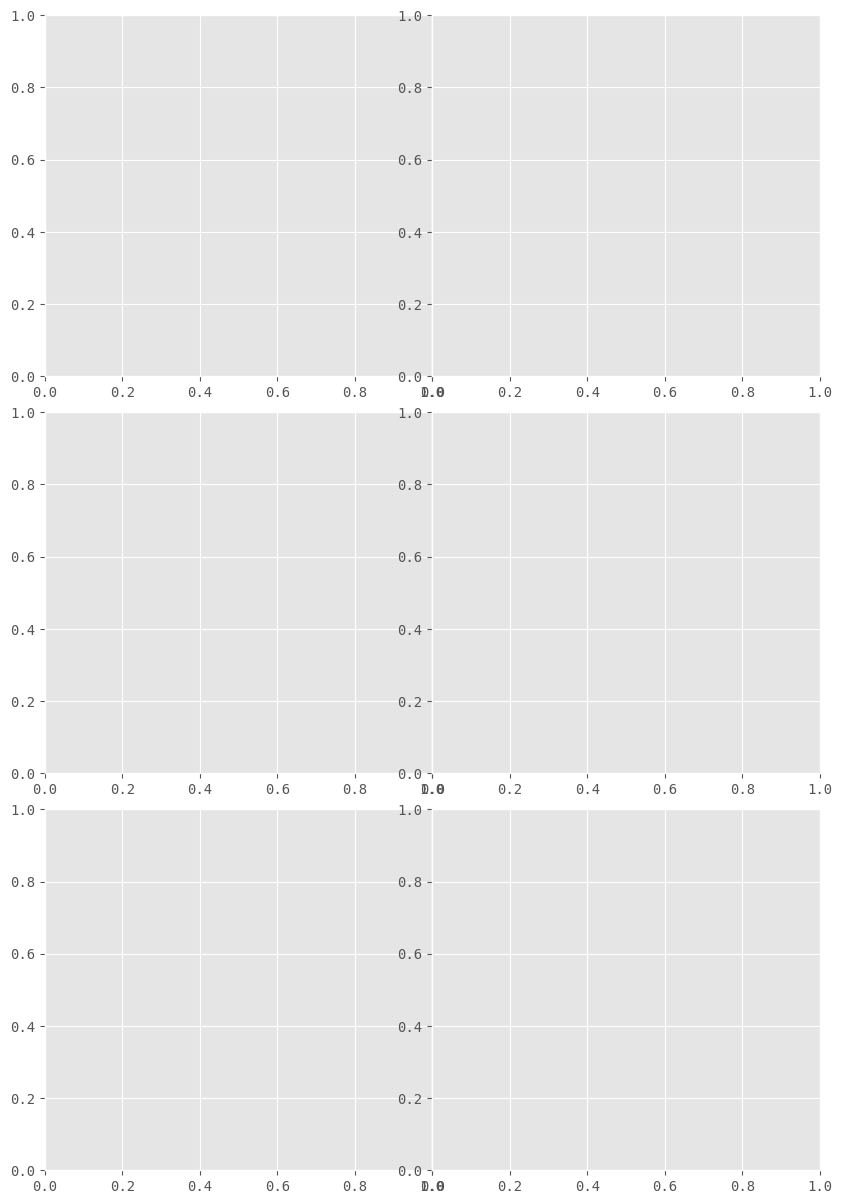

In [88]:
matplotlib.rc('font',family='monospace')
plt.style.use('ggplot')


fig, axs = plt.subplots(3,2, figsize=(10, 15), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .1, wspace=0)

axs = axs.ravel()

count = 0
legend = []
for year, idx in zip([1991,1996,2001,2006,2011,2016], range(6)):
    data = tsne_embedding[df['year']<=year]
    scatter = axs[idx].scatter(data=data,x='x',y='y',s=6,c=data['hue'],cmap="Set1")
    axs[idx].set_title('published until {}'.format(year),**{'fontsize':'10'})
    axs[idx].axis('off')

plt.suptitle("all NIPS proceedings clustered by topic",**{'fontsize':'14','weight':'bold'})
plt.figtext(.51,0.95,'unsupervised topic modeling with NMF based on textual content + 2D-embedding with t-SNE:', **{'fontsize':'10','weight':'light'}, ha='center')


fig.legend(legend_list,topics,loc=(0.1,0.89),ncol=3)
plt.subplots_adjust(top=0.85)

plt.show()

In [92]:
print(type(nmf))
print(type(best_model))

<class 'sklearn.decomposition._nmf.NMF'>
<class 'gensim.models.nmf.Nmf'>
